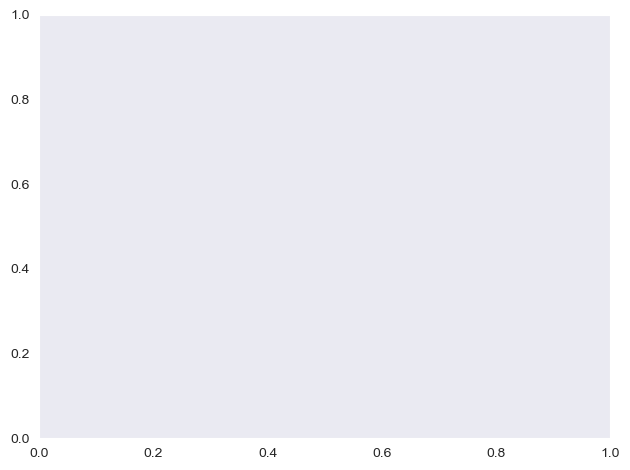

In [11]:
import numpy as np
import cv2 as cv
import medpy.io
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means
from scipy import ndimage
from scipy.signal import medfilt2d
from skimage import morphology

79


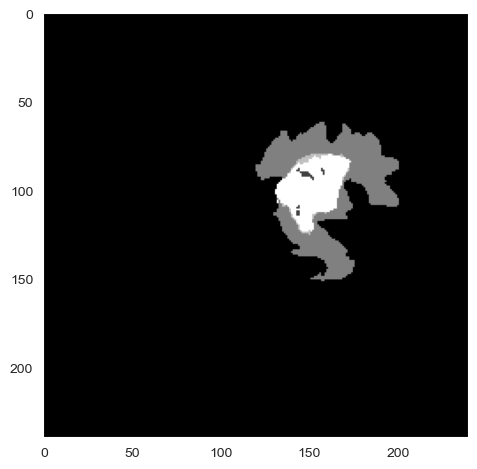

In [13]:
OT_path = "/Users/nicklu/JHU/2022Fall/Computer Vision/final project/fall2022CV/BRATS2015_Training/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain_3more.XX.XX.OT.54529/VSD.Brain_3more.XX.XX.OT.54529.mha"

tumor_data, _ = medpy.io.load(OT_path)

# find Z
Z = 0
max_sum = 0
for i in range(0,tumor_data.shape[2]):
    cur_sum = np.sum(tumor_data[:,:,i])
    if cur_sum > max_sum:
        max_sum = cur_sum
        Z = i
print(Z)
plt.grid(False)
plt.imshow(tumor_data[:,:,Z], cmap='gray')
mask = tumor_data[:,:,Z] != 0
mask = np.array(mask).astype(int)

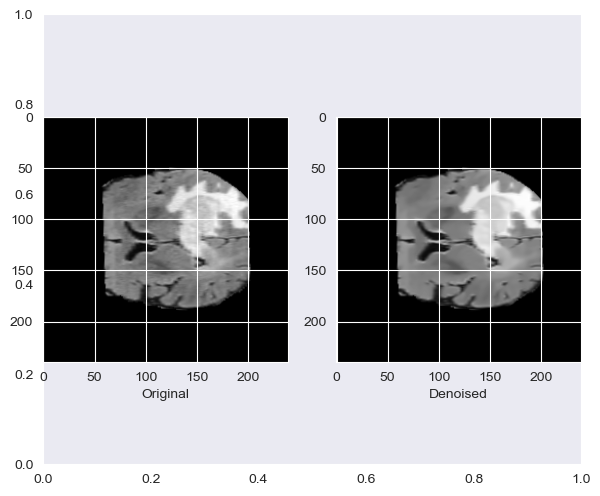

In [15]:
plt.rcParams["figure.autolayout"] = True

Flair_path = "/Users/nicklu/JHU/2022Fall/Computer Vision/final project/fall2022CV/BRATS2015_Training/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain.XX.O.MR_Flair.54524/VSD.Brain.XX.O.MR_Flair.54524.mha"

i = Z
image_data, _ = medpy.io.load(Flair_path)
image_data = image_data[:,:, i]

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("Original")
ax1.imshow(image_data, cmap='gray')

image_data_denoised =  denoise_nl_means(image_data, h=15, fast_mode=True, preserve_range=True)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("Denoised")
ax2.imshow(image_data_denoised, cmap='gray')
fig.savefig("preprocess.pdf", bbox_inches = 'tight')

[[8.0817394e-02]
 [3.2475299e+02]
 [5.3737958e+02]
 [1.1171000e+02]
 [3.9121179e+02]
 [2.3084679e+02]
 [2.7467505e+02]
 [5.7161865e+02]
 [3.5270694e+02]
 [1.7277165e+02]
 [5.3729675e+01]
 [4.3421695e+02]
 [3.0406647e+02]
 [4.9131638e+02]
 [6.1253796e+02]]


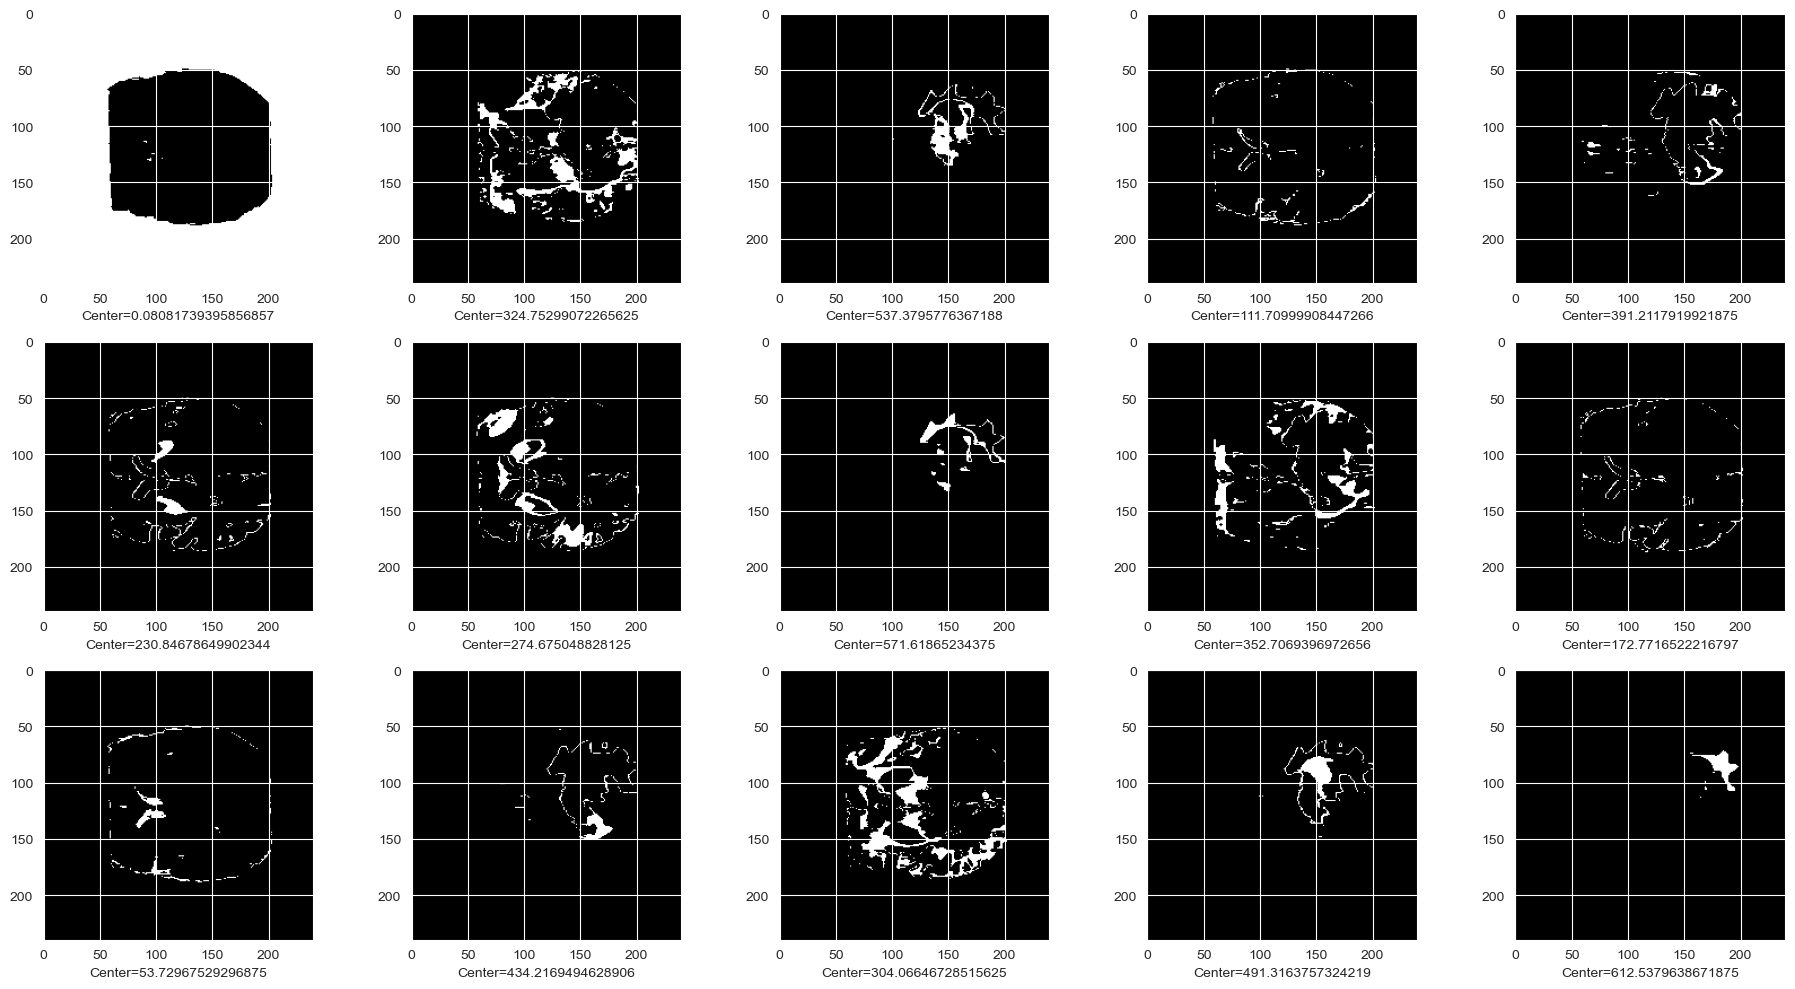

In [10]:
image_denoised = image_data_denoised.reshape((-1,1))
image_denoised = np.float32(image_denoised)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 50, 4.0)
K = 15
ret,label,center=cv.kmeans(image_denoised,K,None,criteria,100,cv.KMEANS_PP_CENTERS)
label += 1
print(center)

fig = plt.figure(figsize=(20, 10))

for i in range(1,K+1):
    ax = fig.add_subplot(3,5,i)
    ax.set_xlabel(f"Center={center[i-1][0]}")
    temp_label = label.copy()
    temp_label[temp_label != i] = 0
    # temp_center = np.uint8(center)
    # res = temp_center[temp_label.flatten()-1]
    res2 = temp_label.reshape(image_data.shape)
    ax.imshow(-1*res2, cmap='binary')


fig.savefig("cluster.png", bbox_inches = 'tight')


[14  7  2 13 11  4  8  1 12  6]
[[612.53796]
 [571.61865]
 [537.3796 ]
 [491.31638]
 [434.21695]
 [391.2118 ]
 [352.70694]
 [324.753  ]
 [304.06647]
 [274.67505]]
112.79253 429.44824
[[612.53796]
 [571.61865]
 [537.3796 ]
 [491.31638]
 [434.21695]]
Diff =  [198.6007]


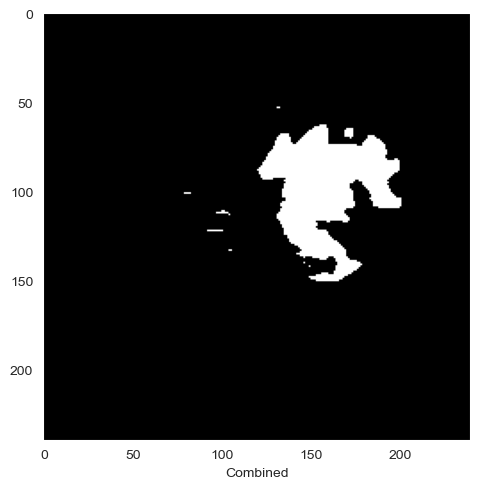

In [18]:
index = np.array(center[:,0]).argsort()[-10:][::-1]
print(index)
print(center[index])
mean = np.mean(center[index])
std = np.std(center[index])
print(std, mean)
diff = -150.2468+2.9188*std-0.0109*center[index[0]]+0.0001*mean*center[index[0]]
index = np.array([i for i in index if center[i] > center[index[0]]-diff])
print(center[index])
print("Diff = ", diff)
temp_label = label.copy()
temp_label = np.array([1 if i in index+1 else 0 for i in temp_label])
res2 = temp_label.reshape(image_data.shape)

plt.rcParams["figure.figsize"] = (5,5)
# kernel = np.ones((2,2),np.uint8)
# res2 = cv.morphologyEx(res2.astype('uint8'), cv.MORPH_OPEN, kernel)
# kernel = np.ones((2,2),np.uint8)
# res2 = cv.morphologyEx(res2.astype('uint8'), cv.MORPH_CLOSE, kernel)
# res2 = morphology.area_opening(res2, connectivity=1)
# res2 = morphology.area_closing(res2, connectivity=1)
# res2 = ndimage.binary_fill_holes(res2).astype(int)
# #
# res2 = medfilt2d(res2, (3,3))
plt.grid(False)
plt.xlabel('Combined')
plt.imshow(-1*res2, cmap='binary')
plt.savefig('combined.pdf')

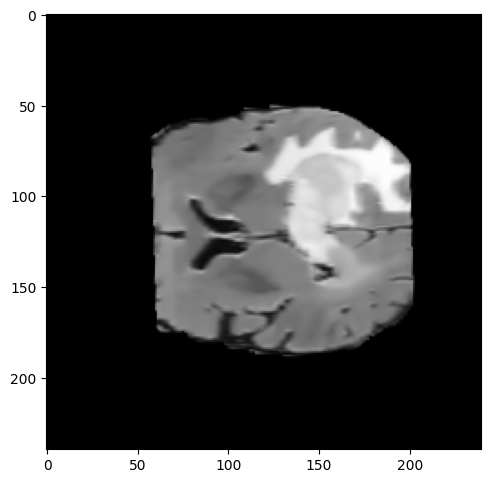

In [6]:
plt.imshow(image_data_denoised, cmap='gray')

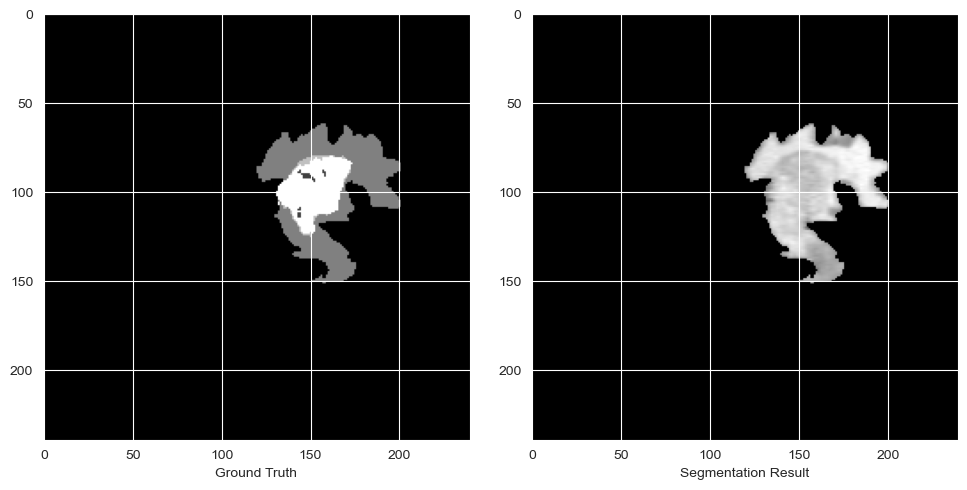

In [9]:
tumor_region_data = np.multiply(image_data, mask)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("Ground Truth")
ax1.imshow(tumor_data[:,:,Z], cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("Segmentation Result")
ax2.imshow(tumor_region_data, cmap='gray')


fig.savefig('result.pdf')